### UFID: 13399251 <br>
### Name: Rishabh Khanna<br>
### Project: Comparison of GAN and VAE<br>
### Course: Machine Learning<br>
### Semster: Fall 2020

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image,make_grid
from tqdm import tqdm
import imageio
import numpy as np
import matplotlib
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import torchvision
from ipywidgets import IntProgress
matplotlib.style.use('ggplot')

VAE

In [2]:
bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='../input/data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='../input/data', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

Extracting ../input/data\MNIST\raw\train-images-idx3-ubyte.gz to ../input/data\MNIST\raw


Extracting ../input/data\MNIST\raw\train-labels-idx1-ubyte.gz to ../input/data\MNIST\raw


Extracting ../input/data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../input/data\MNIST\raw


Extracting ../input/data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../input/data\MNIST\raw
Processing...


c:\users\risha\appdata\local\programs\python\python37\lib\site-packages\torchvision\datasets\mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [3]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

In [4]:
# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [6]:
def train_vae(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
#         data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [7]:
def test_vae():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
#             data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [8]:
for epoch in range(1, 15):
    train_vae(epoch)
    test_vae()

Train Epoch: 1 [0/60000 (0%)]	Loss: 546.977148


c:\users\risha\appdata\local\programs\python\python37\lib\site-packages\torch\nn\functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [10000/60000 (17%)]	Loss: 184.531719
Train Epoch: 1 [20000/60000 (33%)]	Loss: 173.741328
Train Epoch: 1 [30000/60000 (50%)]	Loss: 163.149834
Train Epoch: 1 [40000/60000 (67%)]	Loss: 164.725801
Train Epoch: 1 [50000/60000 (83%)]	Loss: 163.170820
====> Epoch: 1 Average loss: 179.2621
====> Test set loss: 162.2801
Train Epoch: 2 [0/60000 (0%)]	Loss: 157.102441
Train Epoch: 2 [10000/60000 (17%)]	Loss: 157.139248
Train Epoch: 2 [20000/60000 (33%)]	Loss: 152.129707
Train Epoch: 2 [30000/60000 (50%)]	Loss: 154.139482
Train Epoch: 2 [40000/60000 (67%)]	Loss: 165.028418
Train Epoch: 2 [50000/60000 (83%)]	Loss: 153.972363
====> Epoch: 2 Average loss: 158.0705
====> Test set loss: 155.3296
Train Epoch: 3 [0/60000 (0%)]	Loss: 150.449316
Train Epoch: 3 [10000/60000 (17%)]	Loss: 149.269600
Train Epoch: 3 [20000/60000 (33%)]	Loss: 142.354424
Train Epoch: 3 [30000/60000 (50%)]	Loss: 154.365430
Train Epoch: 3 [40000/60000 (67%)]	Loss: 145.834951
Train Epoch: 3 [50000/60000 (83%)]	Loss: 1

In [9]:
with torch.no_grad():
    z = torch.randn(64, 2)
    sample = vae.decoder(z)
    save_image(sample.view(64, 1, 28, 28), '/VAE' + '.png')

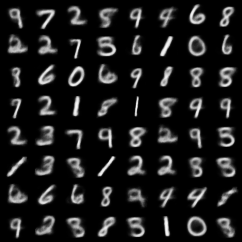

In [10]:
from IPython.display import Image
Image('/VAE.png')

GAN

In [11]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

In [12]:
# learning parameters
batch_size = 256
epochs = 100
sample_size = 64 # fixed sample size
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
train_data = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [14]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [16]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)

In [17]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [18]:
# loss function
criterion = nn.BCELoss()

In [19]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [20]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [21]:
# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [22]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [23]:
noise = create_noise(sample_size, nz)

In [24]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [25]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz)).detach()
            data_real = image
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)
    # create the final fake image for the epoch
    # generated_img = generator(noise).cpu().detach()
    # images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

235it [00:09, 24.95it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:12, 18.35it/s]

Epoch 0 of 100
Generator loss: 1.69651628, Discriminator loss: 1.14951658




235it [00:09, 25.42it/s]                                                                                               
  1%|█                                                                                 | 3/234 [00:00<00:09, 24.00it/s]

Epoch 1 of 100
Generator loss: 2.81018639, Discriminator loss: 1.03476548


235it [00:09, 25.87it/s]                                                                                               
  1%|█                                                                                 | 3/234 [00:00<00:09, 23.62it/s]

Epoch 2 of 100
Generator loss: 1.96978951, Discriminator loss: 1.08045745


235it [00:09, 25.68it/s]                                                                                               
  1%|█                                                                                 | 3/234 [00:00<00:10, 22.39it/s]

Epoch 3 of 100
Generator loss: 1.16333687, Discriminator loss: 1.14579201


235it [00:09, 25.72it/s]                                                                                               
  1%|█                                                                                 | 3/234 [00:00<00:10, 21.13it/s]

Epoch 4 of 100
Generator loss: 1.97279239, Discriminator loss: 1.09522665


235it [00:09, 25.58it/s]                                                                                               
  1%|█                                                                                 | 3/234 [00:00<00:10, 22.73it/s]

Epoch 5 of 100
Generator loss: 1.69468498, Discriminator loss: 1.20191312


235it [00:09, 25.66it/s]                                                                                               
  1%|█                                                                                 | 3/234 [00:00<00:10, 22.22it/s]

Epoch 6 of 100
Generator loss: 2.38416409, Discriminator loss: 0.97645211


235it [00:09, 25.50it/s]                                                                                               
  1%|█                                                                                 | 3/234 [00:00<00:09, 24.59it/s]

Epoch 7 of 100
Generator loss: 2.78481174, Discriminator loss: 0.65669078


235it [00:09, 25.56it/s]                                                                                               
  1%|█                                                                                 | 3/234 [00:00<00:11, 20.41it/s]

Epoch 8 of 100
Generator loss: 3.18629813, Discriminator loss: 0.48101047


235it [00:09, 25.38it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:12, 18.52it/s]

Epoch 9 of 100
Generator loss: 3.20033956, Discriminator loss: 0.42264149


235it [00:09, 25.31it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:12, 18.69it/s]

Epoch 10 of 100
Generator loss: 2.81831837, Discriminator loss: 0.56088930


235it [00:09, 25.31it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:12, 18.69it/s]

Epoch 11 of 100
Generator loss: 2.70792127, Discriminator loss: 0.51506585


235it [00:09, 25.16it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:12, 18.87it/s]

Epoch 12 of 100
Generator loss: 2.94624138, Discriminator loss: 0.51160264


235it [00:09, 25.12it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:11, 19.61it/s]

Epoch 13 of 100
Generator loss: 2.78991914, Discriminator loss: 0.53613889


235it [00:09, 25.09it/s]                                                                                               
  1%|█                                                                                 | 3/234 [00:00<00:11, 19.61it/s]

Epoch 14 of 100
Generator loss: 3.15370107, Discriminator loss: 0.47290826


235it [00:09, 25.02it/s]                                                                                               
  2%|█▍                                                                                | 4/234 [00:00<00:11, 19.29it/s]

Epoch 15 of 100
Generator loss: 3.31703949, Discriminator loss: 0.46036151


235it [00:09, 24.95it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:12, 18.35it/s]

Epoch 16 of 100
Generator loss: 3.05827141, Discriminator loss: 0.44431555


235it [00:09, 24.88it/s]                                                                                               
  1%|█                                                                                 | 3/234 [00:00<00:10, 23.08it/s]

Epoch 17 of 100
Generator loss: 2.99081755, Discriminator loss: 0.54019082


235it [00:09, 24.87it/s]                                                                                               
  1%|█                                                                                 | 3/234 [00:00<00:10, 21.90it/s]

Epoch 18 of 100
Generator loss: 2.87644196, Discriminator loss: 0.50939125


235it [00:09, 24.25it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:12, 18.69it/s]

Epoch 19 of 100
Generator loss: 2.93578887, Discriminator loss: 0.50899214


235it [00:09, 24.42it/s]                                                                                               
  1%|█                                                                                 | 3/234 [00:00<00:11, 20.27it/s]

Epoch 20 of 100
Generator loss: 2.68861103, Discriminator loss: 0.60037923


235it [00:09, 24.63it/s]                                                                                               
  1%|█                                                                                 | 3/234 [00:00<00:10, 22.90it/s]

Epoch 21 of 100
Generator loss: 2.52779150, Discriminator loss: 0.58761615


235it [00:09, 24.46it/s]                                                                                               
  1%|█                                                                                 | 3/234 [00:00<00:10, 22.90it/s]

Epoch 22 of 100
Generator loss: 2.56054401, Discriminator loss: 0.53137499


235it [00:09, 24.36it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:12, 18.52it/s]

Epoch 23 of 100
Generator loss: 2.51874232, Discriminator loss: 0.62013841


235it [00:09, 24.30it/s]                                                                                               
  1%|█                                                                                 | 3/234 [00:00<00:10, 21.90it/s]

Epoch 24 of 100
Generator loss: 2.65036583, Discriminator loss: 0.61147642


235it [00:09, 24.40it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:11, 19.80it/s]

Epoch 25 of 100
Generator loss: 2.54015756, Discriminator loss: 0.58455783


235it [00:09, 24.20it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:12, 18.35it/s]

Epoch 26 of 100
Generator loss: 2.54672933, Discriminator loss: 0.61549610


235it [00:09, 24.23it/s]                                                                                               
  1%|█                                                                                 | 3/234 [00:00<00:11, 20.13it/s]

Epoch 27 of 100
Generator loss: 2.21329951, Discriminator loss: 0.71331483


235it [00:09, 24.18it/s]                                                                                               
  1%|█                                                                                 | 3/234 [00:00<00:10, 22.06it/s]

Epoch 28 of 100
Generator loss: 2.50879288, Discriminator loss: 0.59210056


235it [00:09, 24.32it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:11, 20.00it/s]

Epoch 29 of 100
Generator loss: 2.52831745, Discriminator loss: 0.66013288


235it [00:09, 24.31it/s]                                                                                               
  2%|█▍                                                                                | 4/234 [00:00<00:11, 19.23it/s]

Epoch 30 of 100
Generator loss: 2.38587332, Discriminator loss: 0.64884061


235it [00:09, 24.16it/s]                                                                                               
  1%|█                                                                                 | 3/234 [00:00<00:09, 23.26it/s]

Epoch 31 of 100
Generator loss: 2.35420537, Discriminator loss: 0.66252255


235it [00:09, 24.14it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:11, 20.00it/s]

Epoch 32 of 100
Generator loss: 2.24422741, Discriminator loss: 0.71706098


235it [00:09, 24.05it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:12, 18.18it/s]

Epoch 33 of 100
Generator loss: 2.15830255, Discriminator loss: 0.68485874


235it [00:09, 23.76it/s]                                                                                               
  1%|█                                                                                 | 3/234 [00:00<00:10, 21.13it/s]

Epoch 34 of 100
Generator loss: 1.93744123, Discriminator loss: 0.76326454


235it [00:10, 22.99it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:14, 16.39it/s]

Epoch 35 of 100
Generator loss: 2.16941285, Discriminator loss: 0.70090216


235it [00:10, 23.32it/s]                                                                                               
  1%|█                                                                                 | 3/234 [00:00<00:10, 22.22it/s]

Epoch 36 of 100
Generator loss: 2.14441061, Discriminator loss: 0.73775482


235it [00:09, 23.60it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:12, 18.02it/s]

Epoch 37 of 100
Generator loss: 1.93130469, Discriminator loss: 0.77618343


235it [00:09, 23.67it/s]                                                                                               
  1%|█                                                                                 | 3/234 [00:00<00:10, 22.39it/s]

Epoch 38 of 100
Generator loss: 1.96724451, Discriminator loss: 0.76791620


235it [00:09, 23.57it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:12, 18.02it/s]

Epoch 39 of 100
Generator loss: 2.05838752, Discriminator loss: 0.78426975


235it [00:10, 23.36it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:13, 16.95it/s]

Epoch 40 of 100
Generator loss: 1.99504483, Discriminator loss: 0.73640567


235it [00:10, 23.31it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:12, 18.02it/s]

Epoch 41 of 100
Generator loss: 2.06251168, Discriminator loss: 0.74754059


235it [00:10, 23.30it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:14, 16.39it/s]

Epoch 42 of 100
Generator loss: 1.88471782, Discriminator loss: 0.82010072


235it [00:10, 23.09it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:12, 18.02it/s]

Epoch 43 of 100
Generator loss: 1.80416954, Discriminator loss: 0.82936311


235it [00:10, 23.08it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:12, 18.52it/s]

Epoch 44 of 100
Generator loss: 1.83260727, Discriminator loss: 0.84335172


235it [00:10, 22.98it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:15, 15.27it/s]

Epoch 45 of 100
Generator loss: 1.74587953, Discriminator loss: 0.85538638


235it [00:10, 22.80it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:13, 16.81it/s]

Epoch 46 of 100
Generator loss: 1.78014612, Discriminator loss: 0.85196692


235it [00:10, 22.86it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:12, 18.18it/s]

Epoch 47 of 100
Generator loss: 1.75506759, Discriminator loss: 0.87335801


235it [00:10, 22.84it/s]                                                                                               
  1%|█                                                                                 | 3/234 [00:00<00:11, 19.48it/s]

Epoch 48 of 100
Generator loss: 1.63597023, Discriminator loss: 0.92468232


235it [00:10, 22.57it/s]                                                                                               
  1%|█                                                                                 | 3/234 [00:00<00:12, 18.99it/s]

Epoch 49 of 100
Generator loss: 1.76807010, Discriminator loss: 0.87398970


235it [00:10, 22.41it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:14, 16.39it/s]

Epoch 50 of 100
Generator loss: 1.81675720, Discriminator loss: 0.84222555


235it [00:10, 22.57it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:12, 17.86it/s]

Epoch 51 of 100
Generator loss: 1.81919169, Discriminator loss: 0.83544493


235it [00:10, 22.45it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:13, 17.70it/s]

Epoch 52 of 100
Generator loss: 1.80908060, Discriminator loss: 0.83042181


235it [00:10, 22.30it/s]                                                                                               
  1%|█                                                                                 | 3/234 [00:00<00:10, 21.28it/s]

Epoch 53 of 100
Generator loss: 1.76229262, Discriminator loss: 0.85575181


235it [00:10, 22.36it/s]                                                                                               
  2%|█▍                                                                                | 4/234 [00:00<00:11, 19.57it/s]

Epoch 54 of 100
Generator loss: 1.67658067, Discriminator loss: 0.88397461


235it [00:10, 22.20it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:12, 17.86it/s]

Epoch 55 of 100
Generator loss: 1.74590302, Discriminator loss: 0.86843193


235it [00:10, 22.07it/s]                                                                                               
  1%|█                                                                                 | 3/234 [00:00<00:10, 22.06it/s]

Epoch 56 of 100
Generator loss: 1.73690283, Discriminator loss: 0.88916612


235it [00:10, 22.04it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:11, 19.61it/s]

Epoch 57 of 100
Generator loss: 1.62988877, Discriminator loss: 0.90743959


235it [00:10, 22.17it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:11, 19.61it/s]

Epoch 58 of 100
Generator loss: 1.60999095, Discriminator loss: 0.92922086


235it [00:10, 22.03it/s]                                                                                               
  1%|█                                                                                 | 3/234 [00:00<00:11, 19.61it/s]

Epoch 59 of 100
Generator loss: 1.70675170, Discriminator loss: 0.89065158


235it [00:10, 21.94it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:11, 19.42it/s]

Epoch 60 of 100
Generator loss: 1.58620977, Discriminator loss: 0.93522167


235it [00:10, 21.77it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:13, 16.67it/s]

Epoch 61 of 100
Generator loss: 1.60021687, Discriminator loss: 0.93514937


235it [00:10, 21.69it/s]                                                                                               
  1%|█                                                                                 | 3/234 [00:00<00:10, 21.58it/s]

Epoch 62 of 100
Generator loss: 1.56525540, Discriminator loss: 0.94241500


235it [00:10, 21.58it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:12, 19.05it/s]

Epoch 63 of 100
Generator loss: 1.58804572, Discriminator loss: 0.94262189


235it [00:10, 21.54it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:11, 19.80it/s]

Epoch 64 of 100
Generator loss: 1.61356068, Discriminator loss: 0.91830337


235it [00:11, 20.90it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:16, 14.49it/s]

Epoch 65 of 100
Generator loss: 1.59379900, Discriminator loss: 0.92848808


235it [00:11, 21.29it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:11, 19.61it/s]

Epoch 66 of 100
Generator loss: 1.62808359, Discriminator loss: 0.93587440


235it [00:11, 21.26it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:17, 13.25it/s]

Epoch 67 of 100
Generator loss: 1.60470939, Discriminator loss: 0.92388493


235it [00:11, 21.29it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:15, 15.38it/s]

Epoch 68 of 100
Generator loss: 1.52108395, Discriminator loss: 0.95956486


235it [00:10, 21.47it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:13, 17.24it/s]

Epoch 69 of 100
Generator loss: 1.51067615, Discriminator loss: 0.95324826


235it [00:10, 21.44it/s]                                                                                               
  1%|█                                                                                 | 3/234 [00:00<00:12, 17.96it/s]

Epoch 70 of 100
Generator loss: 1.52210259, Discriminator loss: 0.96925920


235it [00:11, 21.33it/s]                                                                                               
  1%|█                                                                                 | 3/234 [00:00<00:11, 20.69it/s]

Epoch 71 of 100
Generator loss: 1.50075519, Discriminator loss: 0.97468179


235it [00:11, 21.32it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:14, 15.62it/s]

Epoch 72 of 100
Generator loss: 1.48795974, Discriminator loss: 0.98307937


235it [00:11, 21.16it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:14, 15.50it/s]

Epoch 73 of 100
Generator loss: 1.49668443, Discriminator loss: 0.97296560


235it [00:11, 21.10it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:12, 18.69it/s]

Epoch 74 of 100
Generator loss: 1.45344830, Discriminator loss: 0.99687207


235it [00:11, 21.03it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:13, 17.54it/s]

Epoch 75 of 100
Generator loss: 1.50216055, Discriminator loss: 0.97067577


235it [00:11, 20.94it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:13, 17.09it/s]

Epoch 76 of 100
Generator loss: 1.43845618, Discriminator loss: 0.99988937


235it [00:11, 20.90it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:15, 15.15it/s]

Epoch 77 of 100
Generator loss: 1.40126789, Discriminator loss: 1.01173949


235it [00:11, 20.75it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:13, 16.81it/s]

Epoch 78 of 100
Generator loss: 1.37048078, Discriminator loss: 1.03390026


235it [00:11, 20.65it/s]                                                                                               
  1%|█                                                                                 | 3/234 [00:00<00:11, 20.41it/s]

Epoch 79 of 100
Generator loss: 1.39742970, Discriminator loss: 1.03035772


235it [00:11, 20.82it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:12, 18.69it/s]

Epoch 80 of 100
Generator loss: 1.46010077, Discriminator loss: 0.99502212


235it [00:11, 20.69it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:14, 16.00it/s]

Epoch 81 of 100
Generator loss: 1.36357450, Discriminator loss: 1.03190327


235it [00:11, 20.38it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:13, 17.24it/s]

Epoch 82 of 100
Generator loss: 1.37815583, Discriminator loss: 1.02269733


235it [00:11, 20.35it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:12, 18.18it/s]

Epoch 83 of 100
Generator loss: 1.38467634, Discriminator loss: 1.01956046


235it [00:11, 20.62it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:13, 17.70it/s]

Epoch 84 of 100
Generator loss: 1.40682065, Discriminator loss: 1.01424825


235it [00:11, 20.06it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:13, 17.24it/s]

Epoch 85 of 100
Generator loss: 1.36673963, Discriminator loss: 1.04316735


235it [00:11, 20.26it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:13, 17.39it/s]

Epoch 86 of 100
Generator loss: 1.36526561, Discriminator loss: 1.02703369


235it [00:11, 20.33it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:13, 17.09it/s]

Epoch 87 of 100
Generator loss: 1.36801267, Discriminator loss: 1.02430999


235it [00:11, 20.05it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:14, 16.00it/s]

Epoch 88 of 100
Generator loss: 1.33048332, Discriminator loss: 1.05707598


235it [00:11, 19.99it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:13, 16.95it/s]

Epoch 89 of 100
Generator loss: 1.32788932, Discriminator loss: 1.05249429


235it [00:11, 20.16it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:12, 18.35it/s]

Epoch 90 of 100
Generator loss: 1.29877520, Discriminator loss: 1.06006169


235it [00:11, 19.81it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:12, 18.18it/s]

Epoch 91 of 100
Generator loss: 1.34897673, Discriminator loss: 1.03616381


235it [00:12, 19.53it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:14, 15.75it/s]

Epoch 92 of 100
Generator loss: 1.30231178, Discriminator loss: 1.06788349


235it [00:11, 19.91it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:15, 14.93it/s]

Epoch 93 of 100
Generator loss: 1.29672050, Discriminator loss: 1.06181228


235it [00:11, 19.75it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:13, 16.67it/s]

Epoch 94 of 100
Generator loss: 1.29007161, Discriminator loss: 1.06771195


235it [00:11, 19.75it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:12, 18.02it/s]

Epoch 95 of 100
Generator loss: 1.27752614, Discriminator loss: 1.08585894


235it [00:11, 19.65it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:12, 18.30it/s]

Epoch 96 of 100
Generator loss: 1.26205659, Discriminator loss: 1.09131074


235it [00:11, 19.63it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:13, 17.54it/s]

Epoch 97 of 100
Generator loss: 1.24736643, Discriminator loss: 1.08489907


235it [00:11, 19.61it/s]                                                                                               
  1%|▋                                                                                 | 2/234 [00:00<00:14, 16.39it/s]

Epoch 98 of 100
Generator loss: 1.28939641, Discriminator loss: 1.06545866


235it [00:12, 19.36it/s]                                                                                               

Epoch 99 of 100
Generator loss: 1.26751935, Discriminator loss: 1.08222830


In [26]:
with torch.no_grad():
    generated_img = generator(noise).cpu().detach()
    save_image(generated_img.view(64, 1, 28, 28), '/GAN' + '.png')

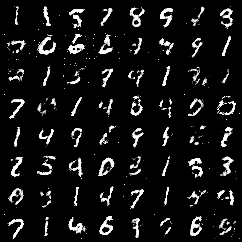

In [27]:
from IPython.display import Image
Image('/GAN.png')

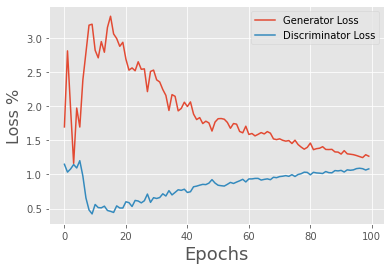

In [53]:
fig = plt.figure()
plt.plot(losses_g,label='Generator Loss')
plt.plot(losses_d,label='Discriminator Loss')
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss %', fontsize=16)
plt.legend()
fig.savefig('vsgraph.png')

MNIST

In [28]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [29]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/images/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/images/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [30]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [31]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [32]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [33]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [34]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      # torch.save(network.state_dict(), '/results/model.pth')
      # torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [35]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [36]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

c:\users\risha\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
c:\users\risha\appdata\local\programs\python\python37\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3004, Accuracy: 751/10000 (8%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.268458
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.268337
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.274000
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.251669
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.236826
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.223578
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.153440
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.096371
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.974112
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.944348
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.839604
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.765900
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.699910
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.690938
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.508514
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.390792
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.280863
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.326454
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.275987
Train Epoch: 1 [12160/6

In [37]:
with torch.no_grad():
    output_gan = network(generated_img)

c:\users\risha\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [38]:
with torch.no_grad():
    z = torch.randn(64, 2)
    sample = vae.decoder(z).view(64,1,28,28)
    output_vae = network(sample)

c:\users\risha\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


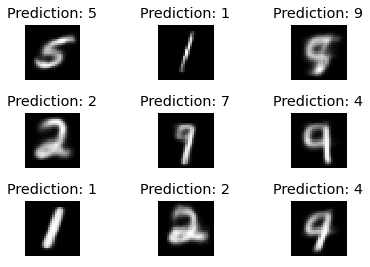

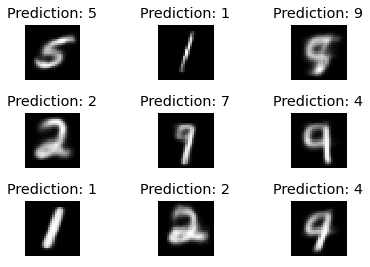

In [39]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(sample[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output_vae.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

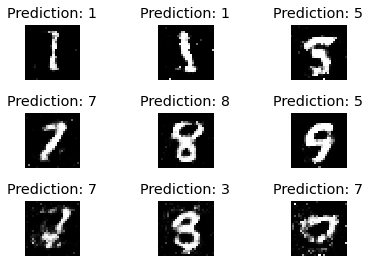

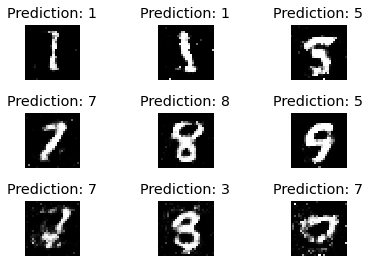

In [40]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(generated_img[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output_gan.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig